# **Quanvolution 2×2 en Digits data set**
*Universidad Nacional Autónoma de México*
## Laboratorio Avanzado de Procesamiento de Imágenes
Académicos:
* Dra. Jimena Olveres Montiel
* Dr. Boris Escalante Ramírez

### Autor: **Sebastián González Juárez**

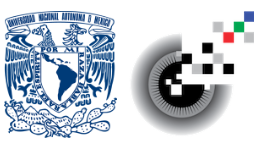

**Resumen:**
Se implemento un pipeline híbrido PyTorch + PennyLane con Quanvolution 2×2 (Ansatz: RY/RZ + CNOT-ring) que genera un mapa 4×4×4 y, vía Flatten + MLP, logra 95.83% de accuracy y F1≈0.959 por clase en Digits.

## 1) Importaciones, seeds y device

In [58]:
import math                         # utilidades matemáticas (p.ej. pi)
import random                       # semilla para reproducibilidad (Python nativo)
import numpy as np                  # arreglos numéricos
import torch                        # framework principal (tensores, autograd)
import torch.nn as nn               # módulos de redes (Linear, Conv, etc.)
import torch.nn.functional as F     # funciones (relu, unfold, etc.)
from torch.utils.data import DataLoader, TensorDataset  # loaders de datos

from sklearn.datasets import load_digits               # dataset Digits (8x8)
from sklearn.model_selection import train_test_split   # para separar train/val/test
from sklearn.metrics import accuracy_score, classification_report  # métricas útiles

import pennylane as qml            # framework cuántico
from pennylane import numpy as pnp # numpy compatible con dispositivos cuánticos

Fijamos semillas para reproducibilidad (PyTorch, NumPy y Python):

In [59]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Elegimos dispositivo de cómputo para PyTorch (CPU es suficiente aquí):

In [60]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch device:", DEVICE)

PyTorch device: cpu


## 2) Configuración experimento (clases, hyperparams, simulador)

Elegimos las dos clases (dígitos):

In [61]:
CLASS_POS = 3            # etiqueta que llamaremos "1" (positivo)
CLASS_NEG = 8            # etiqueta que llamaremos "0" (negativo)

Hyperparámetros del entrenamiento


In [62]:
BATCH_SIZE   = 32        # tamaño de lote (pequeño para que sea ágil)
EPOCHS       = 5        # número de épocas (puedes subirlo después)
LR           = 3e-3      # tasa de aprendizaje (Adam)
WEIGHT_DECAY = 1e-4      # regularización L2

Configuración de la capa cuántica (Quanvolution 2x2):

In [63]:
PATCH_SIZE   = 2         # tamaño del parche (2x2)
QUBITS       = PATCH_SIZE * PATCH_SIZE  # =4, 1 qubit por píxel del parche
LAYERS       = 3         # profundidad (capas) del ansatz cuántico (2–4 típico)

Método de diferenciación en el simulador cuántico:

In [64]:
# "adjoint" es rápido en simulador; "parameter-shift" es el estándar agnóstico a hardware
DIFF_METHOD  = "adjoint"         # modificar para porbar
SHOTS        = None               # None = determinista (sin muestreo); p.ej. 200 si quieres ruido

Post-procesamiento de la salida quanv:

In [65]:
USE_GAP      = False               # True = Global Average Pool (reduce a (B,4)), False = Flatten (B,64)
OUT_DIM      = 1                  # Usaremos salida 1 (logit binario) → BCEWithLogitsLoss

## 3) Carga, binarización y DataLoaders

Cargamos el dataset Digits (imágenes 8x8 en escala 0..16):

In [66]:
digits = load_digits()
X = digits.images.astype(np.float32)   # shape (N, 8, 8)
y = digits.target.astype(np.int64)     # shape (N,)

Filtramos solo dos clases (las elegidas arriba):

In [67]:
mask_bin = np.logical_or(y == CLASS_POS, y == CLASS_NEG)   # booleano: True si es alguna de las dos
X = X[mask_bin]                                            # quedarnos con esas imágenes
y = y[mask_bin]                                            # quedarnos con esas etiquetas

Re-etiquetamos a {0,1} (NEG→0, POS→1) para problema binario:

In [68]:
y = (y == CLASS_POS).astype(np.int64)  # True→1 si era CLASS_POS; False→0 si era CLASS_NEG

Normalizamos a [0,1] dividiendo entre 16 (máximo original del dataset):

In [69]:
X = X / 16.0

Convertimos a tensores PyTorch y agregamos canal (PyTorch usa NCHW → (B,1,8,8)):

In [70]:
X_t = torch.from_numpy(X).unsqueeze(1)    # (N,1,8,8)
y_t = torch.from_numpy(y)                 # (N,)

Partimos en train/val/test de forma estratificada:

In [71]:
X_tr, X_te, y_tr, y_te = train_test_split(X_t, y_t, test_size=0.2, stratify=y_t, random_state=SEED)
X_tr, X_va, y_tr, y_va = train_test_split(X_tr, y_tr, test_size=0.2, stratify=y_tr, random_state=SEED)

Construimos DataLoaders:

In [72]:
train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_va, y_va), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_te, y_te), batch_size=BATCH_SIZE, shuffle=False)

Verifiquemos los Shapes:

In [73]:
print(f"Train: {len(train_loader.dataset)} | Val: {len(val_loader.dataset)} | Test: {len(test_loader.dataset)}")
print("Ejemplo shape batch:", next(iter(train_loader))[0].shape)   # típico: (B,1,8,8)

Train: 228 | Val: 57 | Test: 72
Ejemplo shape batch: torch.Size([32, 1, 8, 8])


## 4) Definición del circuito cuántico (QNode) y capa Quanv 2×2

Dispositivo cuántico (simulador). Usamos default.qubit para portabilidad.

In [74]:
dev = qml.device("default.qubit", wires=QUBITS, shots=SHOTS) # shots=None → expectativas deterministas

Definimos al ansatz cuántico compartido (kernel quanvolucional).
- interface="torch" permite backprop integrado con PyTorch
- diff_method lo tomamos de la configuración (adjoint o parameter-shift)

In [75]:
@qml.qnode(dev, interface="torch", diff_method=DIFF_METHOD)
def quanv_circuit(x_angles, weights):
    # (a) Embedding/feature-map: mapeamos cada píxel del parche a una rotación Ry en su qubit
    for w in range(QUBITS):                 # iteramos sobre los 4 qubits
        qml.RY(x_angles[w], wires=w)        # aplicamos rotación en Y con el ángulo correspondiente

    # (b) Ansatz variacional con L capas: RY-RZ por qubit + entrelazado tipo anillo
    for l in range(LAYERS):                 # L capas apiladas
        for w in range(QUBITS):             # por cada qubit aplicamos 2 rotaciones (RY y RZ)
            qml.RY(weights[l, w, 0], wires=w)
            qml.RZ(weights[l, w, 1], wires=w)
        # entrelazamos en patrón de anillo (0→1, 1→2, 2→3, 3→0)
        qml.CNOT(wires=[0,1])
        qml.CNOT(wires=[1,2])
        qml.CNOT(wires=[2,3])
        qml.CNOT(wires=[3,0])

    # (c) Medición: expectativas de Pauli-Z en cada qubit → produce 4 valores en [-1,1]
    return [qml.expval(qml.PauliZ(w)) for w in range(QUBITS)]


In [76]:
class Quanv2x2(nn.Module):
    def __init__(self):
        super().__init__()
        # Pesos cuánticos (entrenables) del ansatz: (LAYERS, QUBITS, 2)
        self.weights = nn.Parameter(0.1 * torch.randn(LAYERS, QUBITS, 2))
        # Flag de depuración (opcional, solo imprime una vez el dtype de entrada/salida)
        self._dbg_printed = False

    def forward(self, x):
        B, C, H, W = x.shape
        assert C == 1 and H == 8 and W == 8, "Esperaba (B,1,8,8) para Digits."
        
        # Extracción de parches como operador lineal (im2col) ------------------------------------------------------------
        # - Extraemos parches 2x2 con F.unfold → shape: (B, C*k*k, L), con L=16 parches
        patches = F.unfold(x, kernel_size=PATCH_SIZE, stride=PATCH_SIZE)  # (B, 4, 16)
        # - Reordenamos a (B, L, 4) para tener "parches como filas" y 4 valores por parche
        patches = patches.transpose(1, 2)       # (B, 16, 4)
        # - Aplanamos batch y parches para iterar (o vectorizar) más fácil → (B*16, 4)
        patches_flat = patches.reshape(-1, QUBITS)

        # Feature map clásico → ángulos del circuito -----------------------------------------------------------------------
        # - Convertimos intensidades [0,1] a ángulos para Ry: φ = π * x
        angles = torch.pi * patches_flat        # (B*16, 4) mismo dtype que 'x'

        # Aplicación del kernel cuántico compartido a cada parche ----------------------------------------------------------
        outputs = []
        for i in range(angles.shape[0]):        # i recorre todos los parches del batch
            out_i = quanv_circuit(angles[i], self.weights)  # ejecuta QNode → lista de 4 tensores
            outputs.append(torch.stack(out_i))              # (4,)

        # Rearmado espacial (col2im) al mapa 4×4×4 -------------------------------------------------------------------------
        # - Apilamos todas las salidas y rearmamos las dimensiones a (B, 16 parches, 4 canales)
        outputs = torch.stack(outputs, dim=0)               # (B*16, 4)
        outputs = outputs.reshape(B, -1, QUBITS)            # (B, 16, 4)
        # - Reacomodamos a formato "conv": (B, canales=4, 4, 4) — 16 parches → malla 4x4
        outputs = outputs.permute(0, 2, 1)                  # (B, 4, 16)
        outputs = outputs.reshape(B, QUBITS, 8//PATCH_SIZE, 8//PATCH_SIZE)  # (B, 4, 4, 4)

        # Tipo de dato y consistencia (para PyTorch). -------------------------------------------------------------------------
        # - Evitar "Double vs Float" en capas Linear
        outputs = outputs.to(x.dtype)                       # típicamente float32

        # (Opcional) Un solo print para confirmar dtypes al correr la primera vez ---------------------------------------------
        if not self._dbg_printed:
            print("Quanv dtype in/out:", x.dtype, "→", outputs.dtype)
            self._dbg_printed = True

        return outputs       

## 5) Cabeza clásica y ensamblaje del modelo.

Clase HeadSmall: del mapa cuántico al logit.

In [77]:
class HeadSmall(nn.Module):
    def __init__(self, use_gap=False):
        super().__init__()
        self.use_gap = use_gap
        if use_gap:
            self.fc = nn.Linear(4, OUT_DIM)
            self.dropout = nn.Identity()
            self.hidden = nn.Identity()
        else:
            self.hidden  = nn.Linear(4*4*4, 32)   # 64→32
            self.dropout = nn.Dropout(p=0.1)
            self.fc      = nn.Linear(32, OUT_DIM) # 32→1

    def forward(self, z):
        if self.use_gap:
            z = z.mean(dim=(2,3))               # (B,4)
            return self.fc(z)                   # (B,1)
        else:
            z = z.reshape(z.shape[0], -1)       # (B,64)
            z = F.relu(self.hidden(z))          # (B,32)
            z = self.dropout(z)
            return self.fc(z)                   # (B,1)

Clase QuanvModel: ensamblaje Quanv + cabeza.

In [78]:
class QuanvModel(nn.Module):
    def __init__(self, use_gap=True):
        super().__init__()
        self.quanv = Quanv2x2()                # capa cuántica tipo convolución
        self.head  = HeadSmall(use_gap=use_gap) # cabeza clásica final
    def forward(self, x):
        zq = self.quanv(x)                      # (B,4,4,4) mapa de características cuánticas
        logits = self.head(zq)                  # (B,1) salida sin sigmoide (logit)
        return logits                           # devolvemos logits (mejor numéricamente para BCEWithLogitsLoss)


## 6) Entrenamiento y validación.

Criterio de pérdida y optimizador.

Instanciamos el modelo y lo movemos al dispositivo:

In [79]:
model = QuanvModel(use_gap=USE_GAP).to(DEVICE)

Definimos pérdida binaria con logits (numéricamente estable):

In [80]:
criterion = nn.BCEWithLogitsLoss()

Optimizador Adam con pequeño weight decay:

In [81]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [82]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

Función auxiliar: corre una época (train o val)

In [83]:
def run_epoch(dloader, train=True):
    if train:
        model.train()   # modo entrenamiento (activa gradientes)
    else:
        model.eval()    # modo evaluación (desactiva dropout, etc.)

    total_loss, total_correct, total_count = 0.0, 0, 0

    for xb, yb in dloader:
        # Mover batch a dispositivo
        xb = xb.to(DEVICE)                                  # imágenes
        yb = yb.to(DEVICE).float().unsqueeze(1)             # etiquetas a float y shape (B,1)

        # FORWARD: obtener logits (sin sigmoide)
        logits = model(xb)                                   # (B,1)

        # PÉRDIDA
        loss = criterion(logits, yb)                         # escalar

        if train:
            # BACKWARD + STEP
            optimizer.zero_grad()                            # limpiar gradientes
            loss.backward()                                  # backprop (incluye gradientes cuánticos)

            # ------ Chequeo de gradiente (OPCIONAL, solo 1 vez) ------
            if not hasattr(model, "_printed_grad"):
                with torch.no_grad():
                    # Norma L2 del gradiente de los pesos cuánticos (puede ser pequeña pero >0)
                    gnorm = (model.quanv.weights.grad.norm().item()
                             if model.quanv.weights.grad is not None else 0.0)
                print(f"[debug] ||grad(weights_quanv)|| = {gnorm:.3e}")
                model._printed_grad = True
            # ----------------------------------------------------------

            optimizer.step()                                  # actualizar parámetros

        # MÉTRICA: accuracy rápida con umbral 0 sobre el logit (equivale a sigmoide > 0.5)
        preds = (logits.detach() >= 0.0).long()              # (B,1) en {0,1}
        total_correct += (preds.squeeze(1) == yb.long().squeeze(1)).sum().item()
        total_count   += yb.shape[0]
        total_loss    += loss.item() * yb.shape[0]

    avg_loss = total_loss / total_count
    acc      = total_correct / total_count
    return avg_loss, acc


Entrenamiento:

In [84]:
for ep in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader,   train=False)
    scheduler.step(va_loss)
    print(f"Época {ep:02d} | Train: loss={tr_loss:.4f}, acc={tr_acc*100:.1f}% "
          f"| Val: loss={va_loss:.4f}, acc={va_acc*100:.1f}% "
          f"| lr={optimizer.param_groups[0]['lr']:.2e}")


Quanv dtype in/out: torch.float32 → torch.float32
[debug] ||grad(weights_quanv)|| = 1.603e-02
Época 01 | Train: loss=0.6304, acc=68.4% | Val: loss=0.5457, acc=86.0% | lr=3.00e-03
Época 02 | Train: loss=0.4963, acc=87.7% | Val: loss=0.4318, acc=91.2% | lr=3.00e-03
Época 03 | Train: loss=0.3720, acc=95.6% | Val: loss=0.3270, acc=94.7% | lr=3.00e-03
Época 04 | Train: loss=0.2762, acc=95.2% | Val: loss=0.2476, acc=98.2% | lr=3.00e-03
Época 05 | Train: loss=0.1925, acc=97.4% | Val: loss=0.1900, acc=96.5% | lr=3.00e-03


## 7) Evaluación en test y reporte.

Evaluación final en el conjunto de prueba:

In [85]:
model.eval()                                     # modo evaluación
all_logits, all_labels = [], []

In [86]:
with torch.no_grad():                            # no necesitamos gradientes en test
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        logits = model(xb)                       # (B,1)
        all_logits.append(logits.cpu())          # guardamos en CPU para concatenar
        all_labels.append(yb.cpu())

Concatenamos todos los batches:

In [87]:
all_logits = torch.cat(all_logits, dim=0)        # (N_test,1)
all_labels = torch.cat(all_labels, dim=0)        # (N_test,)

Convertimos a predicciones binarias (umbral en 0 sobre el logit):

In [88]:
yhat = (all_logits >= 0.0).long().squeeze(1)     # (N_test,)

Accuracy simple:

In [89]:
acc_test = (yhat == all_labels).float().mean().item()
print(f"Test Accuracy: {acc_test*100:.2f}%")

Test Accuracy: 95.83%


Reporte de clasificación (precision/recall/F1):

In [90]:
print("\nReporte de clasificación (0 = NEG, 1 = POS):")
print(classification_report(all_labels.numpy(), yhat.numpy(), digits=4))


Reporte de clasificación (0 = NEG, 1 = POS):
              precision    recall  f1-score   support

           0     0.9211    1.0000    0.9589        35
           1     1.0000    0.9189    0.9577        37

    accuracy                         0.9583        72
   macro avg     0.9605    0.9595    0.9583        72
weighted avg     0.9616    0.9583    0.9583        72

